# Part 3. Enhancement
The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In
this section, you will design strategies to improve upon the previous model you have built. You are
required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same
way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words
and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and
stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment
classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards
a meaningful improvement.


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from datasets import load_dataset
import numpy as np
import json
import nltk
from gensim.models import FastText
from common_utils import EmbeddingMatrix, CustomDatasetPreparer
np.random.seed(42)
torch.manual_seed(0)

In [67]:
with open('result/word2idx.json', 'r', encoding='utf-8') as f:
    word2idx = json.load(f)

UNK_TOKEN = "<UNK>"
embedding_matrix = np.load('result/embedding_matrix.npy')

In [68]:
EMBEDDING_DIM = 100  
VOCAB_SIZE = max(word2idx.values()) + 1
BATCH_SIZE = 64

In [69]:
# Reference: https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout):
        super(CNN, self).__init__()
        # Create input layer, for the pretrained embedding matrix
        self.embedding = nn.Embedding(vocab_size, embedding_dim) 
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))  

        # Enable back propagation -> Part 3 Task 1, allowing embeddings to be updated
        self.embedding.weight.requires_grad = True 

        # To store a list of Convolutions Layers, for 2-gram, 3-gram, 4-gram, 5-gram, 6-gram models.
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes # fs = N-gram for varying length
        ])

        # Randomly drops some elements in the input tensor as a form of Regulatization, to prevent overfitting
        self.dropout = nn.Dropout(dropout)

        # My attempt to incorporate Attention layer by applying more weights on importat feature? Not really helping actually
        self.attention_layer = nn.Linear(len(filter_sizes) * num_filters, len(filter_sizes) * num_filters) 
        
        # Output the final result => Classes, 2 for our binary classification case
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
    
    def forward(self, x):
        # Shape: (batch_size, sequence_length, embedding_dim)
        x = self.embedding(x) 

        # Reshape to (batch_size, embedding_dim, sequence_length), as per Conv1d's expectation
        x = x.permute(0, 2, 1)

        # Applying ReLU activation function for each N-gram Conv1d layer
        conv_results = [F.relu(conv(x)) for conv in self.convs]

        # To perform max-over-time-pooling, taking the max value across entire sequence length for each filter, reducing the dimentionality of the output
        # Maybe can consider avg_pool1d too
        pool_results = [F.max_pool1d(conv_result, conv_result.shape[2]).squeeze(2) for conv_result in conv_results]
        
        # Concatenate the pooled features
        x = torch.cat(pool_results, 1) 

        # Prevent Overfitting
        x = self.dropout(x)

        # Attention is all you need? (Unfortunately not really in our case :')
        attention_weights = torch.softmax(self.attention_layer(x), dim=1)
        x = x * attention_weights
        
        return self.fc(x)


NUM_FILTERS = 100 
FILTER_SIZES = [2, 3, 4, 5, 6] # Essentially treating single CNN 1 Dimensional as N-gram model (Use the filter size to determine computation with kernel)
DROPOUT = 0.5
LEARNING_RATE = 0.001
EPOCHS = 5
NUM_CLASSES = 2 

model = CNN(VOCAB_SIZE, EMBEDDING_DIM, NUM_CLASSES, NUM_FILTERS, FILTER_SIZES, DROPOUT)


In [70]:
dataset_preparer = CustomDatasetPreparer(
    dataset_name="rotten_tomatoes",
    word2idx=word2idx,
    unk_token=UNK_TOKEN,
    max_len=512,
    batch_size=BATCH_SIZE
)

train_loader, val_loader, test_loader = dataset_preparer.get_dataloaders()

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) #Idea: Can use Adam / MiniAdam / SGD with Momentum
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct_preds = 0
        total_samples = 0
        for batch in train_loader:
            inputs, extra_features, lengths, labels = batch
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        scheduler.step()
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in test_loader:
            inputs, extra_features, lengths, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_preds / total_samples
    return avg_loss, accuracy

train(model, train_loader, val_loader, criterion, optimizer, EPOCHS, scheduler)
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/5], Train Loss: 0.6687, Train Accuracy: 0.5644, Val Loss: 0.5851, Val Accuracy: 0.7139
Epoch [2/5], Train Loss: 0.4753, Train Accuracy: 0.7812, Val Loss: 0.7064, Val Accuracy: 0.6773
Epoch [3/5], Train Loss: 0.3367, Train Accuracy: 0.8668, Val Loss: 0.6136, Val Accuracy: 0.7336
Epoch [4/5], Train Loss: 0.1927, Train Accuracy: 0.9392, Val Loss: 0.5292, Val Accuracy: 0.7861
Epoch [5/5], Train Loss: 0.1621, Train Accuracy: 0.9508, Val Loss: 0.5371, Val Accuracy: 0.7795
Test Loss: 0.5048, Test Accuracy: 0.7842


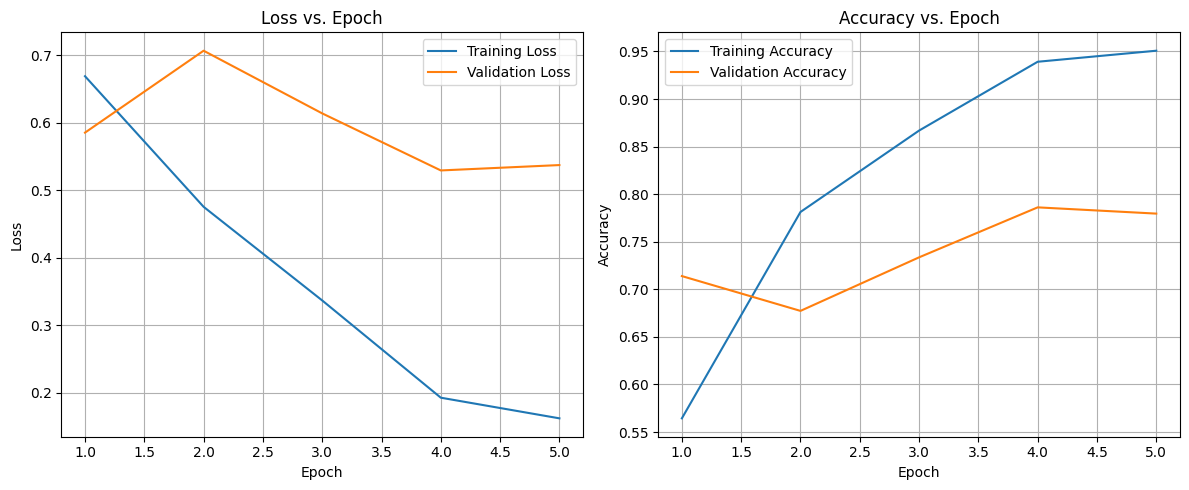

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [73]:
from torchviz import make_dot
import torch

sample_input = torch.randint(0, VOCAB_SIZE, (1, 100)).to('cpu') 
output = model(sample_input)
dot = make_dot(output, params=dict(model.named_parameters()))

dot.format = 'png'  
dot.render('result/cnn_model_graph')


'result\\cnn_model_graph.png'

# Question 3. Enhancement
(a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).
   
(b) Report the accuracy score on the test set when applying your method to deal with OOV words
in Part 3.2.
   
(c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).
   
(d) Report the accuracy scores of CNN on the test set (Part 3.4).
   
(e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set
using your improved model.
   
(f) Compare the results across different solutions above and describe your observations with possible discussions.


### Archive

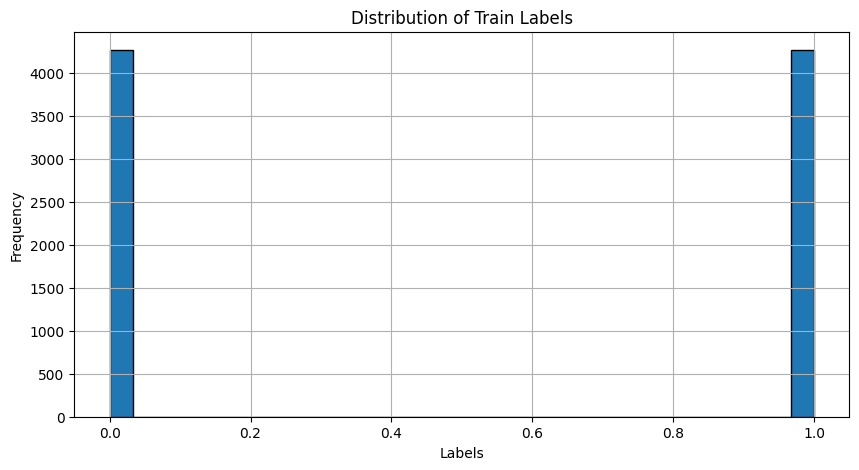

In [74]:
import matplotlib.pyplot as plt

# Plot the distribution for train labels
dataset = load_dataset("rotten_tomatoes")
train_labels = [example['label'] for example in dataset['train']]

plt.figure(figsize=(10, 5))
plt.hist(train_labels, bins=30, edgecolor='black')
plt.title('Distribution of Train Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

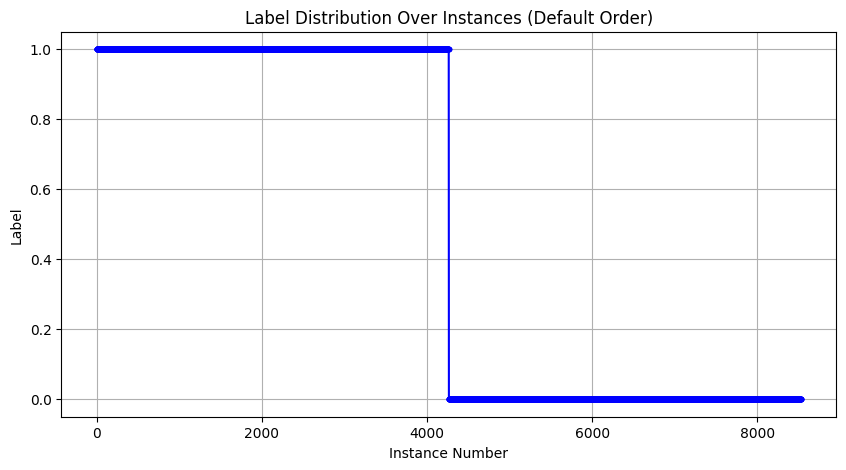

In [75]:
import matplotlib.pyplot as plt

# Plot the distribution for train labels
train_labels = [example['label'] for example in dataset['train']]

# Assuming 'train_labels' is already defined as a list of labels
# Create the x-axis based on the number of labels
x_axis = range(len(train_labels))

plt.figure(figsize=(10, 5))
plt.plot(x_axis, train_labels, marker='o', linestyle='-', color='blue', markersize=3)  # Plot each label with a line
plt.title('Label Distribution Over Instances (Default Order)')
plt.xlabel('Instance Number')
plt.ylabel('Label')
plt.grid(True)
plt.show()

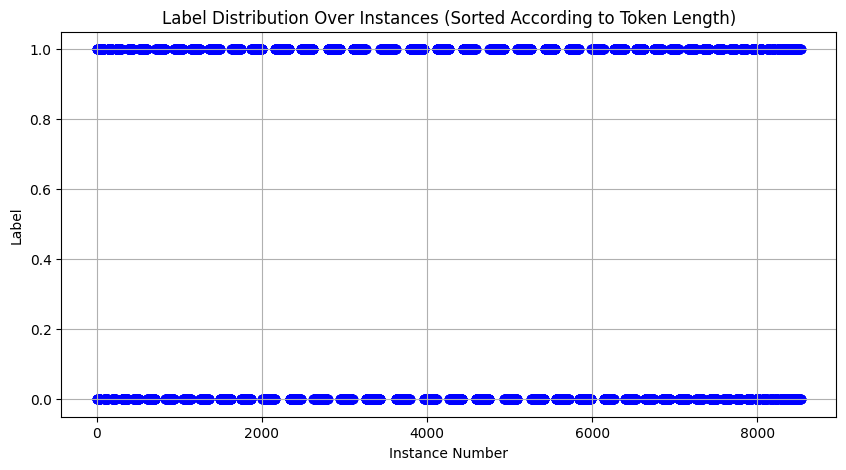

In [76]:
# Step 1: Tokenize the texts
def tokenize_and_get_lengths(texts, word2idx, unk_token, max_len=512):
    lengths = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        token_ids = [word2idx.get(word, word2idx[unk_token]) for word in tokens]
        token_ids = token_ids[:max_len]  # Truncate to max_len
        lengths.append(len(token_ids))  # Get the length of tokenized sequence
    return lengths

# Step 2: Get lengths of the tokenized sequences in the training set
train_texts = [example['text'] for example in dataset['train']]
train_labels = [example['label'] for example in dataset['train']]

# Tokenize and get the lengths of each text
token_lengths = tokenize_and_get_lengths(train_texts, word2idx, UNK_TOKEN)

# Step 3: Sort the labels based on the token lengths
sorted_indices = sorted(range(len(token_lengths)), key=lambda i: token_lengths[i])
train_labels_sorted = [train_labels[i] for i in sorted_indices]

# Step 4: Plot the sorted labels
x_axis = range(len(train_labels_sorted))

plt.figure(figsize=(10, 5))
plt.scatter(x_axis, train_labels_sorted, marker='o', color='blue')  # Plot each label with a line
plt.title('Label Distribution Over Instances (Sorted According to Token Length)')
plt.xlabel('Instance Number')
plt.ylabel('Label')
plt.grid(True)
plt.show()


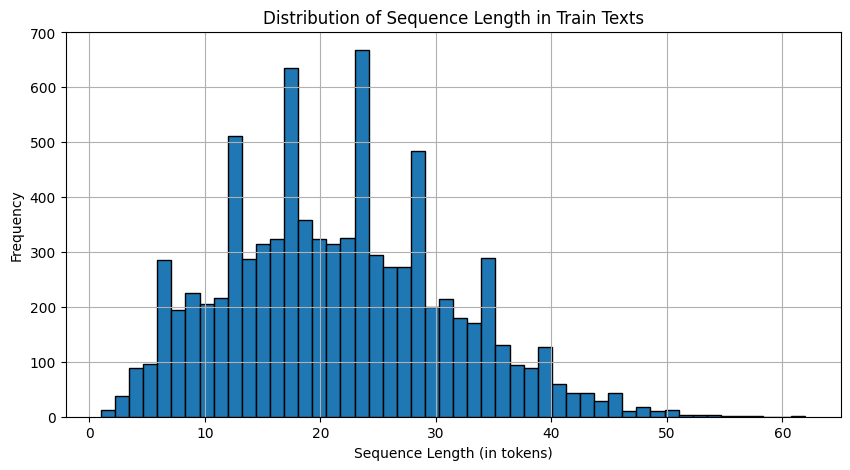

In [77]:
import matplotlib.pyplot as plt
import nltk

def tokenize(texts, word2idx, unk_token, max_len=None):
    """
    Tokenize the given texts and optionally truncate to max length.
    
    :param texts: List of texts to tokenize.
    :param word2idx: Dictionary mapping words to their corresponding IDs.
    :param unk_token: Token to use for unknown words.
    :param max_len: Optional maximum length to truncate each tokenized sequence.
    :return: List of tokenized sequences as lists of token IDs.
    """
    tokenized = []
    for text in texts:
        tokens = nltk.word_tokenize(text.lower())
        token_ids = [word2idx.get(word, word2idx[unk_token]) for word in tokens]
        if max_len:
            token_ids = token_ids[:max_len]  # Truncate to max_len if provided
        tokenized.append(token_ids)
    return tokenized

train_texts = [example['text'] for example in dataset['train']]
train_tokenized = tokenize(train_texts, word2idx, UNK_TOKEN)

# Calculate sequence lengths
sequence_lengths = [len(tokens) for tokens in train_tokenized]

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 5))
plt.hist(sequence_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Sequence Length in Train Texts')
plt.xlabel('Sequence Length (in tokens)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
